 val 정확도가 75%에서 머물고 늘어나지 않음. 테스트 결과도 이상함

In [1]:
import numpy as np
import pandas as pd
import os, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm as tqdm
np.random.seed(42)
# %matplotlib inline

import json
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image

/compuworks/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/compuworks/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/compuworks/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/compuworks/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# Read train labels
labels_df = pd.read_csv('./datasets/labels.csv')\

# Create list of alphabetically sorted labels
dog_breeds = sorted(list(set(labels_df['breed'])))
n_classes = len(dog_breeds)

# Map each label string to an integer label
class_to_num = dict(zip(dog_breeds, range(n_classes)))

# Define image path
train_dir = './datasets/images/train'

# Choose a test image randomly to input
img_path =  os.path.join(train_dir,np.random.choice(os.listdir(train_dir)))

# Prepare image for model input
img = load_img(img_path, target_size=(256, 256))
x = np.array(img).astype("float32")
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Create ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

Instructions for updating:
Colocations handled automatically by placer.


/compuworks/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

In [4]:
# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
# Create new model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [6]:
x_train = []
y_train = []

for img_path in labels_df['id'].values:
    img_path = os.path.join(train_dir,img_path+'.jpg')
    img = load_img(img_path, target_size=(256, 256, 1))
    x = np.array(img).astype("float32")
    x = preprocess_input(x)
    x_train.append(x)
    y_train.append(class_to_num[labels_df[labels_df['id'] == img_path.split('/')[-1].split('.')[0]]['breed'].values[0]])

X_train = np.array(x_train)
y_train = to_categorical(y_train, num_classes=n_classes)
X_train, y_train = shuffle(X_train, y_train)
# Number of epochs to train
num_epochs = 50

In [7]:
# Fit the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, validation_split = 0.2)

Train on 8177 samples, validate on 2045 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
8177/8177 [==============================] - 42s 5ms/sample - loss: 2.8359 - acc: 0.3366 - val_loss: 1.0902 - val_acc: 0.6738
Epoch 2/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 1.2835 - acc: 0.6226 - val_loss: 0.9384 - val_acc: 0.7066
Epoch 3/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 0.9520 - acc: 0.7131 - val_loss: 0.8355 - val_acc: 0.7452
Epoch 4/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 0.7505 - acc: 0.7717 - val_loss: 0.8776 - val_acc: 0.7345
Epoch 5/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 0.6266 - acc: 0.8014 - val_loss: 0.8097 - val_acc: 0.7447
Epoch 6/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 0.5512 - acc: 0.8251 - val_loss: 0.8275 - val_acc: 0.7491
Epoch 7/50
8177/8177 [==============================] - 34s 4ms/sample - loss: 0.4

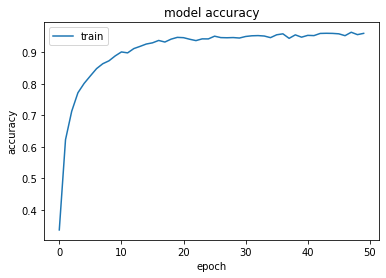

In [8]:
# Plot the accuracy and loss curves
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

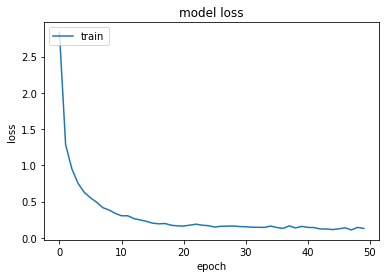

In [9]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Predicted label:  sealyham_terrier


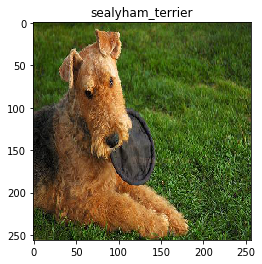

Predicted label:  border_collie


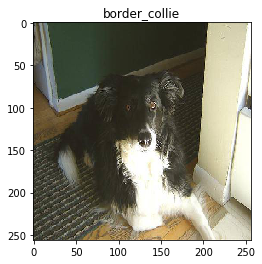

Predicted label:  german_short-haired_pointer


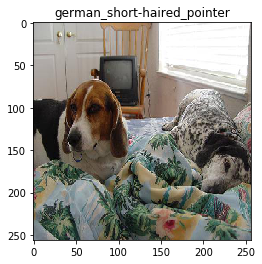

Predicted label:  clumber


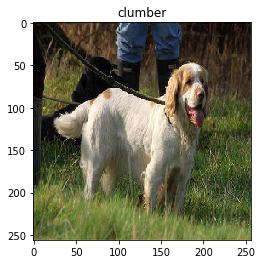

Predicted label:  eskimo_dog


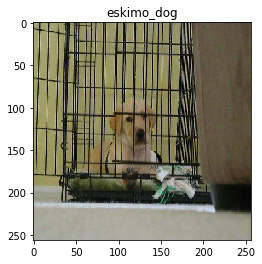

Predicted label:  german_short-haired_pointer


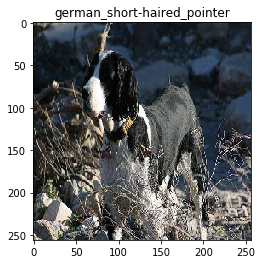

Predicted label:  keeshond


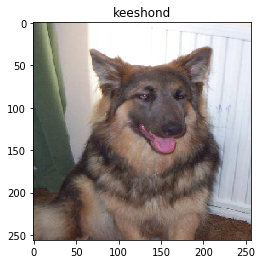

Predicted label:  eskimo_dog


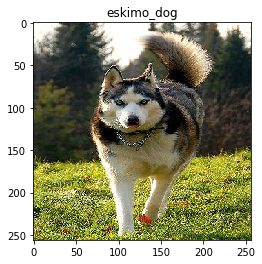

Predicted label:  irish_wolfhound


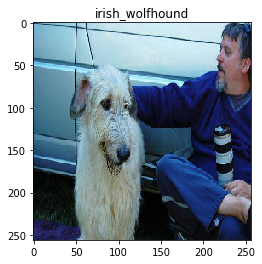

Predicted label:  west_highland_white_terrier


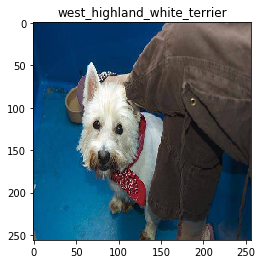

Predicted label:  sealyham_terrier


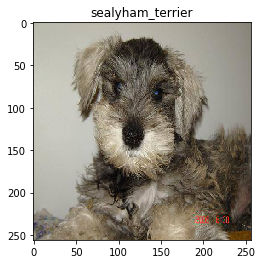

Predicted label:  english_setter


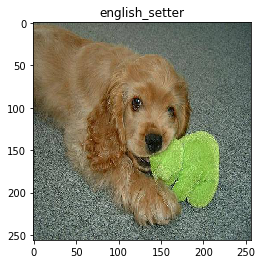

Predicted label:  basenji


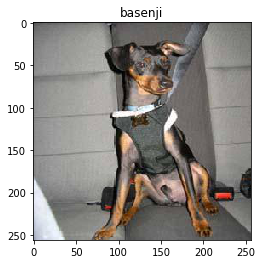

Predicted label:  staffordshire_bullterrier


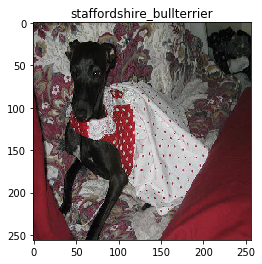

Predicted label:  samoyed


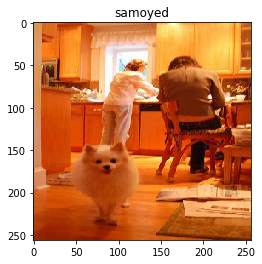

Predicted label:  african_hunting_dog


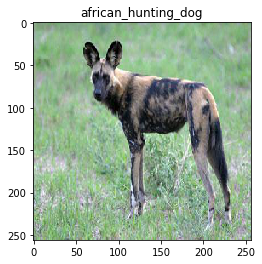

Predicted label:  toy_poodle


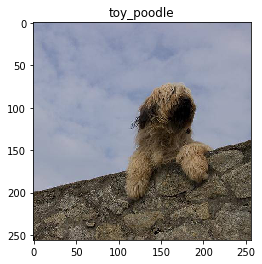

Predicted label:  newfoundland


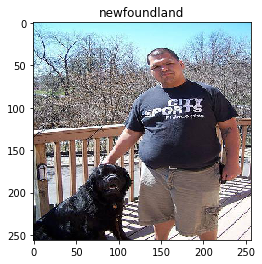

Predicted label:  soft-coated_wheaten_terrier


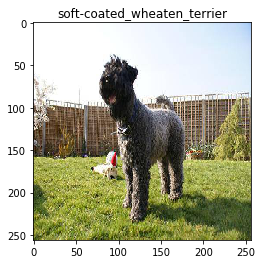

Predicted label:  beagle


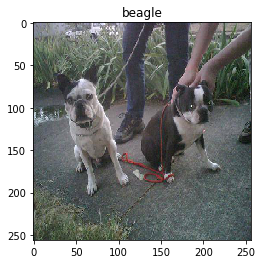

In [12]:
# Load the image and preprocess it
test_dir = './datasets/images/test'

for i in range(20):
#     img_path =  os.path.join(train_dir,np.random.choice(os.listdir(train_dir)))
    img_path =  os.path.join(test_dir,np.random.choice(os.listdir(test_dir)))
    img = image.load_img(img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 3.

    # Get the predictions
    predictions = model.predict(img_tensor)

    # Get the class label with highest prediction score
    label_index = np.argmax(predictions[0])

    # Create a dictionary to map class indices to class labels
    num_to_class = {v: k for k, v in class_to_num.items()}

    # Use the dictionary to map the class index to the corresponding class label
    predicted_label = num_to_class[label_index]

    # Print the predictions and display the image
    print("Predicted label: ", predicted_label)
    plt.imshow(img)
    plt.title(predicted_label)
    plt.show()

In [15]:
x_test = []
y_test = []

for img_path in labels_df['id'].values:
    img_path = os.path.join(test_dir,img_path+'.jpg')
    img = load_img(img_path, target_size=(256, 256, 1))
    x = np.array(img).astype("float32")
    x = preprocess_input(x)
    test.append(x)
    y_test.append(class_to_num[labels_df[labels_df['id'] == img_path.split('/')[-1].split('.')[0]]['breed'].values[0]])
    
    
X_test = np.array(x_test)
y_test = to_categorical(y_test, num_classes=n_classes)
X_test, y_test = shuffle(X_test, y_test)

FileNotFoundError: [Errno 2] No such file or directory: './datasets/images/test/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)